<a href="https://colab.research.google.com/github/bkutlu/adipose_tissue_datasets/blob/master/VisceralAT_lean_obese_mice_Cho_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cho et al study from Mayo

__Excerpts from Abstract__: Single-cell RNA sequencing to create a cellular atlas of APC heterogeneity in mouse visceral adipose tissue. Our analysis identified two distinct populations of adipose tissue-derived stem cells (ASCs) and three distinct populations of preadipocytes (PAs)



We will analyze data using the **kallisto | bustools** `kbtools` from Lior Pachter lab. This notebook is adapted from the incredible resources available [here](https://www.kallistobus.tools/)

## Setup

In [0]:
# This is  used to time the running of the notebook
import time
start_time = time.time()

### Install python packages

In [4]:
!pip install matplotlib
!pip install scikit-learn
!pip install numpy
!pip install scipy

In [2]:
%%time
# `kb` is a wrapper for the kallisto and bustools program, and the kb-python package contains the kallisto and bustools executables.
!pip install kb-python

     |████████████████████████████████| 35.4MB 44.9MB/s 
     |████████████████████████████████| 102kB 11.7MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
  Created wheel for loompy: filename=loompy-3.0.6-cp36-none-any.whl size=47895 sha256=229eb9e169961a5e56119d9f25ea3be75172d16ef940e2a78c60a55d5e1f9b4d
  Stored in directory: /root/.cache/pip/wheels/f9/a4/90/5a98ad83419732b0fba533b81a2a52ba3dbe230a936ca4cdc9
  Created wheel for numpy-groupies: filename=numpy_groupies-0+unknown-cp36-none-any.whl size=28042 sha256=10dc082668bdc982cfa799227a391eabab1a2f4518a03be4d8f920636d3d81ee
  Stored in directory: /root/.cache/pip/wheels/30/ac/83/64d5f9293aeaec63f9539142fc629a41af064cae1b3d8d94aa
Successfully built loompy numpy-groupies
CPU times: user 84.2 ms, sys: 24.1 ms, total: 108 ms
Wall time: 13.8 s


In [6]:
%%time
# Install scanpy and other packages needed for single-cell RNA-seq analysis
!pip install scanpy python-igraph louvain MulticoreTSNE pybiomart

     |████████████████████████████████| 7.2MB 2.7MB/s 
     |████████████████████████████████| 3.2MB 41.1MB/s 
     |████████████████████████████████| 2.2MB 34.7MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp36-cp36m-linux_x86_64.whl size=68502 sha256=6190cd0d372d907bf00cb6c7945a2ec11c95bea25201ab52ad4ed01e1e2508af
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE
CPU times: user 75.4 ms, sys: 21.1 ms, total: 96.5 ms
Wall time: 14.6 s


In [0]:
# Import packages
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io

matplotlib.rcParams.update({'font.size': 12})
%config InlineBackend.figure_format = 'retina'

### Download the kallisto index for mouse

This data consists of cells from a mouse visceral adipose tissue, so we download the mouse index (GRCm38.98 from [Ensembl](https://uswest.ensembl.org/index.html)).

In [9]:
!kb ref -d mouse -i index.idx -g t2g.txt -f1 transcriptome.fasta

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
[2020-05-11 14:18:29,694]    INFO Downloading files for mouse from https://caltech.box.com/shared/static/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz to tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz
[2020-05-11 14:19:46,266]    INFO Extracting files from tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz


In [17]:
!ls cho_et_al/counts_unfiltered/

adata.h5ad     cells_x_genes.barcodes.txt  cells_x_genes.mtx
cells_x_genes  cells_x_genes.genes.txt


## Pseudoalignment and counting

The data we will process was produced with **10xv2**. For a comprehensive list run `kb --list`

In [12]:
!kb --list

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
List of supported single-cell technologies

name         whitelist provided    barcode (file #, start, stop)        umi (file #, start, stop)    read file #    
---------    ------------------    ---------------------------------    -------------------------    -----------    
10XV1        yes                   (2, 0, 0)                            (1, 0, 0)                    0              
10XV2        yes                   (0, 0, 16)                           (0, 16, 26)                  1              
10XV3        yes                   (0, 0, 16)                           (0, 16, 28)                  1              
CELSEQ                             (0, 0, 8)                            (0, 8, 12)                   1        

### Run kallisto and bustools

The following command will generate an RNA count matrix of cells (rows) by genes (columns) in H5AD format, which is a binary format used to store [Anndata](https://anndata.readthedocs.io/en/stable/) objects. Notice that this requires providing the index and transcript-to-gene mapping downloaded in the previous step to the `-i` and `-g` arguments respectively. Also, since the reads were generated with the 10x Genomics Chromium Single Cell v2 Chemistry, the `-x 10xv2` argument is used. To view other supported technologies, run `kb --list`.

__Note:__ To output a [Loom](https://linnarssonlab.org/loompy/format/index.html) file instead, replace the `--h5ad` flag with `--loom`. To obtain the raw matrix output by `kb` instead of the H5AD or Loom converted files, omit these flags.

In [11]:
%%time
# This step runs `kb` to pseudoalign the reads, and then generate the cells x gene matrix in h5ad format.
!kb count -i index.idx -g t2g.txt -x 10xv2 --h5ad -t 2 -o cho_et_al \
https://sra-pub-src-1.s3.amazonaws.com/SRR10305578/High_Fat_S2_L002_R1_001.fastq.gz.1 \
https://sra-pub-src-1.s3.amazonaws.com/SRR10305578/High_Fat_S2_L002_R2_001.fastq.gz.1

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
[2020-05-11 14:35:58,644]    INFO Piping https://sra-pub-src-1.s3.amazonaws.com/SRR10305578/High_Fat_S2_L002_R1_001.fastq.gz.1 to tmp/High_Fat_S2_L002_R1_001.fastq.gz.1
[2020-05-11 14:35:58,645]    INFO Piping https://sra-pub-src-1.s3.amazonaws.com/SRR10305578/High_Fat_S2_L002_R2_001.fastq.gz.1 to tmp/High_Fat_S2_L002_R2_001.fastq.gz.1
[2020-05-11 14:35:58,646]    INFO Generating BUS file from
[2020-05-11 14:35:58,646]    INFO         tmp/High_Fat_S2_L002_R1_001.fastq.gz.1
[2020-05-11 14:35:58,646]    INFO         tmp/High_Fat_S2_L002_R2_001.fastq.gz.1
[2020-05-11 15:10:05,363]    INFO Sorting BUS file cho_et_al/output.bus to tmp/output.s.bus
[2020-05-11 15:12:32,561]    INFO Whitelist not provided
[2020-05-11 15:12:32,562]    IN

## Basic QC

In [0]:
# Setup

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

Next, we populate an object we call `adata` with the gene names, counts, and later other information about the dataset. First, we note that `adata` will contain *gene* counts. Throughout this notebook we focus on single-cell *gene* quantification, but it is possible to learn something about isoforms from all kinds of single-cell RNA-seq data. The ideal technology for studying isoforms is SMART-seq, but it is possible to also extract isoform information from Drop-seq and other droplet based single-cell RNA-seq technologies. For more on this see these two papers:

- Ntranos, Vasilis, Lynn Yi, Páll Melsted, and Lior Pachter. "[A discriminative learning approach to differential expression analysis for single-cell RNA-seq](https://www.nature.com/articles/s41592-018-0303-9)." Nature methods 16, no. 2 (2019): 163-166.

- Booeshaghi, A. Sina, Zizhen Yao, Cindy van Velthoven, Kimberly Smith, Bosiljka Tasic, Hongkui Zeng, and Lior Pachter. "[Isoform cell type specificity in the mouse primary motor cortex](https://www.biorxiv.org/content/10.1101/2020.03.05.977991v3.full)." bioRxiv (2020).

[Anndata objects](https://icb-anndata.readthedocs-hosted.com/en/stable/anndata.AnnData.html) are a key concept in Scanpy, and very powerful for organizing single-cell RNA-seq analysis.


In [0]:
# import data
adata = anndata.read('cho_et_al/counts_unfiltered/adata.h5ad')
adata.var["gene_id"] = adata.var.index.values

t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
adata.var.index = adata.var["gene_name"]

In [19]:
adata

AnnData object with n_obs × n_vars = 257796 × 55421 
    var: 'gene_id', 'gene_name'

## Populate the anndata object

In [0]:
# Parameter settings we use throughout the notebook

num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 50
num_NCA = 10

# Filtering criteria
cell_threshold = 100
gene_threshold = 3

mito_criteria = 30

n_top_genes = 5000

n_bins = 20

flavor="seurat"

The `flavor = seurat` setting is related to normalization of the data, and is an attempt by Scanpy to allow for analyses concordant with what one would obtain with the R package Seurat. Read more about this [here](https://icb-scanpy.readthedocs-hosted.com/en/1.4.4.post1/api/scanpy.api.pp.filter_genes_dispersion.html).

In [0]:
adata.obs["cell_counts"] = adata.X.sum(axis=1)
adata.var["gene_counts"] = nd(adata.X.sum(axis=0))

adata.obs["n_genes"] = nd((adata.X>0).sum(axis=1))
adata.var["n_cells"] = nd((adata.X>0).sum(axis=0))

mito_genes = adata.var_names.str.startswith('mt-')
adata.obs["percent_mito"] = adata[:,mito_genes].X.sum(axis=1)/adata.X.sum(axis=1)*100

## Anndata features

### Examine the knee plot

The "knee plot" was introduced in the Drop-seq paper: 
- Macosko et al., [Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets](https://www.cell.com/fulltext/S0092-8674(15)00549-8), 2015. DOI:10.1016/j.cell.2015.05.002

In this plot cells are ordered by the number of UMI counts associated to them (shown on the *x*-axis), and the fraction of droplets with at least that number of cells is shown on the *y*-axis:

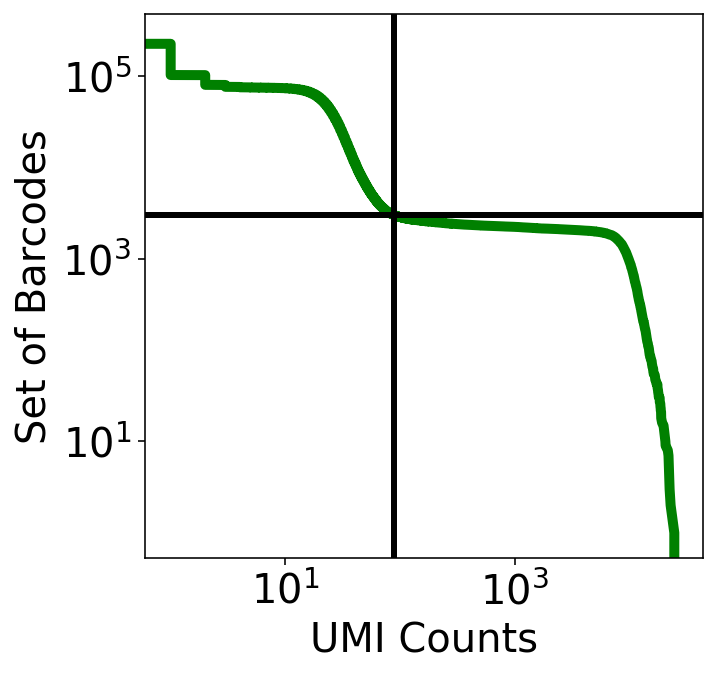

In [31]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
expected_num_cells = 3000#@param {type:"integer"}
knee = np.sort(nd(adata.X.sum(axis=1)))[::-1]

fig, ax = plt.subplots(figsize=(5, 5))

x = knee
y = range(len(knee))

ax.loglog(x, y, linewidth=5, color="g")

ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.show()